# Preliminaries

## Re-generate the token table

The cell below uses Jupyter's "magic" commands to execute the whole first notebook and create `token_table.csv`.
- In the first line, we use `%%capture` to suppress all the messages that the first notebook normally would print to the screen. 
- In the second line, we use `%run` to run the whole notebook from start to finish.

This takes a little time. When it's done, the CSV file should appear.

In [1]:
%%capture
%run "03 - VF vs Seneca - Part 1.ipynb"

## Import statements

As usual, we need to some extra code that isn't part of base Python. [**Pandas**](https://pandas.pydata.org/) and [**Matplotlib**](https://matplotlib.org/stable/index.html) are probably familiar by now. The third package, [**scikit-learn**](https://scikit-learn.org/stable/) is a machine-learning package that provides some very useful methods for dimensionality reduction and classification.

In [2]:
# provides functionality for tabular data
import pandas as pd

# provides plotting
from matplotlib import pyplot as plt

# dimensionality reduction
from sklearn.decomposition import PCA

## Load the data

This should load the token table from the CSV file and display it on the screen.

In [3]:
token_table = pd.read_csv('token_table.csv')
display(token_table)

,urn,author,title,token,lemma,upos,mood,tense,voice,person,number,case,gender
0,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,Soror,soror,NOUN,NaN,NaN,NaN,NaN,Sing,Nom,Fem
1,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,Tonantis,Tonantis,NOUN,NaN,NaN,NaN,NaN,Sing,Gen,Masc
2,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,(,(,PUNCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,hoc,hic,DET,NaN,NaN,NaN,NaN,Sing,Acc,Neut
4,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,enim,enim,PART,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111319,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,tibi,tu,PRON,NaN,NaN,NaN,NaN,Sing,Dat,Masc
111320,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,praemia,praemium,NOUN,NaN,NaN,NaN,NaN,Plur,Acc,Neut
111321,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,reddi,reddo,VERB,NaN,Pres,Pass,NaN,NaN,NaN,NaN
111322,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,?,?,PUNCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature extraction

## Cleaning the data

As we did last time, here we create a new table leaving out any tokens labelled as punctuation.

In [6]:
no_punct = token_table.loc[token_table.upos!='PUNCT']

## Calculating lemma frequencies

### Feature tallies

Here we use the Pandas method `crosstab()` to create a feature frequency table. If we cross-tabulate **author** and **title**, on the one hand, against **lemma** on the other, then the resulting table has one row for each **author** - **title** pair, and one column for each possible value in **lemma**. The values tell us how many times each lemma occurs in each text.

### Normalization

As we did last time, we're going to normalize our counts by dividing by the length of each text. That gives us frequencies instead of raw tallies, making the texts more easily comparable.

Because the resulting frequencies are often very low, we're going to follow standard practice in stylometry and multiple them all by 1000. That means that values represent the expected count for a given feature in a sample of 1000 words.

The cell below produces a table with one for every possible lemma.

In [75]:
# tally lemma counts and normalize
lemma_freq = pd.crosstab([no_punct.author, no_punct.title], no_punct.lemma, normalize='index')

# multiply by 1000
lemma_freq = lemma_freq * 1000

# display the result
display(lemma_freq)

lemma                                 o  (h)arena        ):  -gestans  \
author   title                                                          
Seneca   Herc_Fur    0.000000  0.000000  0.000000  0.000000  0.000000   
         Herc_Oet    0.000000  0.000000  0.000000  0.000000  0.087773   
         Medea       0.000000  0.000000  0.175131  0.000000  0.000000   
         Oedipus     0.000000  0.000000  0.000000  0.000000  0.000000   
         Phaedra     0.000000  0.000000  0.000000  0.000000  0.000000   
         Phoenissae  0.000000  0.000000  0.000000  0.000000  0.000000   
         Thyestes    0.000000  0.000000  0.000000  0.157704  0.000000   
         Troades     0.000000  0.000000  0.000000  0.000000  0.000000   
Val_Flac Thebaid_01  0.168520  0.000000  0.337041  0.337041  0.000000   
         Thebaid_02  0.000000  0.000000  0.000000  0.000000  0.000000   
         Thebaid_03  0.194818  0.000000  0.194818  0.000000  0.000000   
         Thebaid_04  0.187336  0.000000  0.187336  0.187336  0.000000   
         Thebaid_05  0.000000  0.000000  0.000000  0.000000  0.000000   
         Thebaid_06  0.191241  0.000000  0.191241  0.000000  0.000000   
         Thebaid_07  0.213767  0.213767  0.000000  0.000000  0.000000   
         Thebaid_08  0.000000  0.000000  0.000000  0.000000  0.000000   

lemma                -triumphos        ..       ...      ....     .....  ...  \
author   title                                                           ...   
Seneca   Herc_Fur      0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         Herc_Oet      0.087773  0.087773  0.000000  0.000000  0.000000  ...   
         Medea         0.000000  0.175131  0.000000  0.000000  0.000000  ...   
         Oedipus       0.000000  0.337667  0.000000  0.000000  0.000000  ...   
         Phaedra       0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         Phoenissae    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         Thyestes      0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         Troades       0.000000  0.000000  0.000000  0.000000  0.000000  ...   
Val_Flac Thebaid_01    0.000000  0.000000  0.337041  0.000000  0.000000  ...   
         Thebaid_02    0.000000  0.000000  0.000000  0.213995  0.000000  ...   
         Thebaid_03    0.000000  0.000000  0.194818  0.000000  0.000000  ...   
         Thebaid_04    0.000000  0.000000  0.187336  0.000000  0.000000  ...   
         Thebaid_05    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         Thebaid_06    0.000000  0.000000  0.191241  0.000000  0.191241  ...   
         Thebaid_07    0.000000  0.000000  0.213767  0.000000  0.000000  ...   
         Thebaid_08    0.000000  0.000000  0.299850  0.000000  0.000000  ...   

lemma                †peranti†  †profundis†  †pulchro†  †quaeat†     †quus  \
author   title                                                               
Seneca   Herc_Fur      0.00000     0.000000   0.000000  0.000000  0.000000   
         Herc_Oet      0.00000     0.000000   0.000000  0.000000  0.000000   
         Medea         0.00000     0.000000   0.000000  0.000000  0.000000   
         Oedipus       0.00000     0.000000   0.000000  0.000000  0.000000   
         Phaedra       0.00000     0.000000   0.000000  0.000000  0.000000   
         Phoenissae    0.00000     0.000000   0.000000  0.000000  0.000000   
         Thyestes      0.00000     0.000000   0.000000  0.000000  0.000000   
         Troades       0.00000     0.000000   0.000000  0.000000  0.000000   
Val_Flac Thebaid_01    0.00000     0.000000   0.000000  0.000000  0.000000   
         Thebaid_02    0.00000     0.000000   0.000000  0.000000  0.000000   
         Thebaid_03    0.00000     0.000000   0.194818  0.000000  0.194818   
         Thebaid_04    0.00000     0.000000   0.000000  0.000000  0.000000   
         Thebaid_05    0.00000     0.000000   0.000000  0.000000  0.000000   
         Thebaid_06    0.00000     0.191241   0.000000  0.000000  0.000000

But as we learned last time, many of these columns are unhelpful to us because they're dedicated to lemmata that occur very rarely in the corpus. Let's see if we can do some more precise shaping of this feature set based on overall frequency in the corpus.

### Overall counts

Let's calculate again the corpus-wide count for each lemma. These will allow us to order the lemmata by frequency and identify the **most frequent words** as well as **hapax legomena**.

In [76]:
# calculate corpus-wide counts for all lemmata
lemma_count = no_punct.lemma.value_counts()

### MFWs

What are the most frequent words in the corpus?

In [79]:
pd.DataFrame(lemma_count[:25])

,count
lemma,
que,3052
et,2314
qui,1447
sum,1132
hic,1044
in,905
tu,765
non,703
ego,686


### Hapax legomena

As we saw last time, over half of the lemmata in this list have a count of 1: they are **hapax legomena** (i.e. ἅπαξ λεγόμενα, "said once").

In [80]:
pd.DataFrame(lemma_count[lemma_count==1])

,count
lemma,
germino,1
Priami,1
Bella,1
conversae,1
Laomedon,1
...,...
macs,1
profare,1
poscuntur,1


### Stoplist

A **stoplist** is a list of features we will exclude from our analysis. For this notebook, I'm somewhat arbitrarily going to create a lemma stoplist including all lemmata that occur fewer than 10 times in the corpus.

In [28]:
# identify the lemmata for which count is less than 10
lemma_stop = lemma_count.index.values[lemma_count<10]

# how many?
print(len(lemma_stop), 'lemmata to be excluded')

12679 lemmata to be excluded


### Revised lemma table

Let's redo the lemma table. After we calculate the frequencies, we drop all the columns that are in the stoplist. The data frame `drop()` method lets us drop rows or columns, so we specify that we're talking about columns here.

In [74]:
# tally lemma counts and normalize
lemma_freq = pd.crosstab([no_punct.author, no_punct.title], no_punct.lemma, normalize='index')

# multiply by 1000
lemma_freq = lemma_freq * 1000

# reorder columns according to overall frequency
lemma_freq = lemma_freq[lemma_count.index.values]

# drop columns in the stoplist
lemma_freq = lemma_freq.drop(lemma_stop, axis='columns')

# display the result
display(lemma_freq)

lemma                      que         et        qui        sum        hic  \
author   title                                                               
Seneca   Herc_Fur    23.364486  22.845275  15.186916  14.148494  10.514019   
         Herc_Oet    16.940226  19.485649  16.501360  21.153340  11.322742   
         Medea       21.716287  21.190893  19.614711  18.563923  10.858144   
         Oedipus     21.104170  22.792504  12.662502  11.143002   6.922168   
         Phaedra     23.518086  23.105488  13.890799  13.478201   8.251960   
         Phoenissae  18.015854  20.898391  22.099448  23.540716  19.216911   
         Thyestes    20.501498  25.705725  15.928087  23.182463  13.877937   
         Troades     22.096235  24.422154  19.188836  16.281436  15.409216   
Val_Flac Thebaid_01  54.095046  28.985507  15.503876   4.718571   8.594540   
         Thebaid_02  61.844639  31.457308  10.271774   1.497967  10.913760   
         Thebaid_03  49.483733  28.443405  14.026885   3.311903   6.623807   
         Thebaid_04  42.150618  30.348445  12.738854   3.746722  10.116148   
         Thebaid_05  36.678343  25.757264  15.042242   3.502988  11.539254   
         Thebaid_06  50.870147  24.478868  14.151845   1.529929  11.091987   
         Thebaid_07  46.387345  24.796922  14.108593   7.481830  12.612227   
         Thebaid_08  45.577211  23.388306  10.794603   6.896552  10.194903   

lemma                       in         tu       non        ego        iam  \
author   title                                                              
Seneca   Herc_Fur     7.658359   7.268951  5.970924   7.139148   3.245067   
         Herc_Oet    11.234969  10.181691  8.601773  12.112701   5.705258   
         Medea        7.880911   8.756567  7.880911   6.479860   5.429072   
         Oedipus      8.779335   7.935168  8.441668   5.402668   4.052001   
         Phaedra      7.426764   9.764819  8.114427   5.638839   2.475588   
         Phoenissae  12.250781  12.250781  8.887821  11.770358   5.044439   
         Thyestes    12.143195   4.258003  9.462230   5.204226   5.204226   
         Troades      5.960169   6.977758  8.576828   5.378689   2.907399   
Val_Flac Thebaid_01  11.796427   9.437142  5.224132   6.740816   8.088979   
         Thebaid_02   9.415793   5.135887  8.131821   5.349882  11.983736   
         Thebaid_03   7.403078   4.480810  4.870446   5.260082   8.961621   
         Thebaid_04   8.804796   4.870738  4.683402   7.493443   9.554140   
         Thebaid_05   9.066557   8.036266  5.151453   4.739336   9.066557   
         Thebaid_06  11.283228   4.589788  8.032129   3.251100   7.267164   
         Thebaid_07  11.970928  13.681060  7.481830  13.894827   9.191962   
         Thebaid_08  11.994003  12.893553  8.395802   8.095952   9.295352   

lemma                ...      loco  propinquus     iecur  Phasidis     ualeo  \
author   title       ...                                                       
Seneca   Herc_Fur    ...  0.129803    0.129803  0.000000  0.000000  0.000000   
         Herc_Oet    ...  0.000000    0.000000  0.526639  0.000000  0.351093   
         Medea       ...  0.000000    0.000000  0.000000  0.000000  0.000000   
         Oedipus     ...  0.000000    0.168833  0.168833  0.000000  0.000000   
         Phaedra     ...  0.000000    0.000000  0.137533  0.000000  0.000000   
         Phoenissae  ...  0.000000    0.240211  0.240211  0.000000  0.480423   
         Thyestes    ...  0.000000    0.157704  0.157704  0.000000  0.157704   
         Troades     ...  0.145370    0.000000  0.000000  0.000000  0.000000   
Val_Flac Thebaid_01  ...  0.000000    0.168520  0.000000  0.337041  0.000000   
         Thebaid_02  ...  0.641986    0.000000  0.000000  0.000000  0.213995   
         Thebaid_03  ...  0.584454    0.584454  0.000000  0.389636  0.000000   
         Thebaid_04  ...  0.000000    0.000000  0.000000  0.187336  0.000000   
         Thebaid_05  ...  0.000000    0.206058  0.000000  0.412116  0.412116   
        

Much better! We only have 1400 features to deal with here, a 90% reduction from the initial table.

### Visualizing feature distributions

As we saw last time, we can use a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to visualize the distribution of a given feature across the corpus. This can be helpful when comparing classes, say, comparing the 8 books by Valerius Flaccus to the 8 plays by Seneca.

This is the code that we finished with last time. In the first lines, we select a feature and assign it to the variable `feat`: this must be the name of one of the columns in our frequency table. The remainder of the code draws and labels a graph comparing the distribution of that feature across the books of each author.

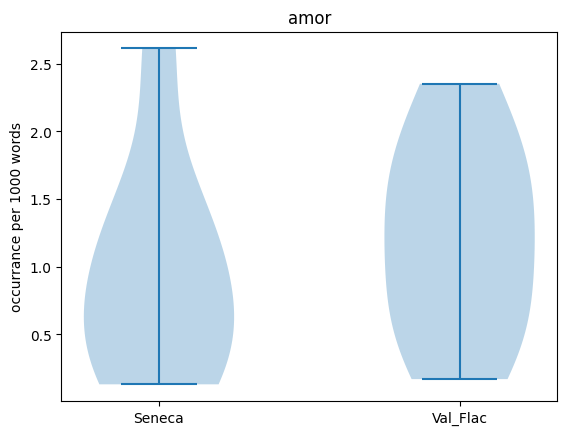

In [98]:
# feature of interest
feat = 'amor'

# create empty list for the labels and data values
labels = []
values = []

# extract labels, data from grouped table
for label, group in lemma_freq.groupby('author'):
    labels.append(label)
    values.append(group[feat])

# create a new plot
fig, ax = plt.subplots()

# plot the values
ax.violinplot(values)

# add labels
ax.set_xticks(range(1, len(labels)+1), labels=labels)
ax.set_ylabel('occurrance per 1000 words')
ax.set_title(feat)

# show
plt.show()

<div class="alert alert-success">
<h3>🤔 Explore the data</h3>

<p style="margin:1em 0em">Before continuing, try replacing <code>amor</code> above with various other lemmata of your choice. You can pick words that seem interesting to you, work through the MFWs listed above, or maybe try some of the words from Bernhard Söllradl's paper.</p>

<p style="margin:1em 0em">If you enter a words that doesn't have a column in the table, you'll get an error. Just pick another word and try again. Note that Patrick's trained language model tends to prefer 'u' over 'v', so for example <code>vir</code> doesn't work but <code>uir</code> does.</p>
    
<p style="margin:1em 0em"><strong>Which words show large differences between the two authors?</strong></p>
</div>

<hr>

# Basic clustering and classification

The next step in our experiment is to try **clustering** the data. This is a common task in stylometry and in data science generally. In the simplest terms, we're trying to spread out all the samples as widely as we can, and see whether they fall into distinct groups, or "clusters".

A related task is **classification**: deciding which group a given sample belongs to. If we have a mathematical model that defines the clusters, we can then use that model to classify an unknown sample.

For example, take a look at the distributions of the feature **que** using the code block above. Now, imagine we come across a text whose authorship is disputed. It uses *-que* at a rate of 22 times per 1000 words. Which of the two authors do you think is most likely to have written it?

## Visualizing multiple features at once

So far we've looked at one feature at a time. But we also know that several, perhaps many, of the lemmata differ between the two authors. Moreover, combining features may bring out information that we don't see otherwise.

Let's start by visualizing just two lemma frequencies at once... say **et** and **que**. We can plot these in a Cartesian space—that is, an x-y plot—with the frequency of **et** as the horizontal axis and that of **que** as the vertical. Each text then becomes a point on this graph, positioned according to its use of the two features.

The code below works much the same as the previous block: the two features of interest are set at the top. The remainder of the cell creates the graph. Drawing a **scatter plot** or x-y graph is really straightforward in Pyplot. Can you see more or less what's going on in each step?

💁🏻‍♂️ Hint: adding the `label=` option to `scatter()` registers the series with a given name. That's how Pyplot is able to create a legend at the end.

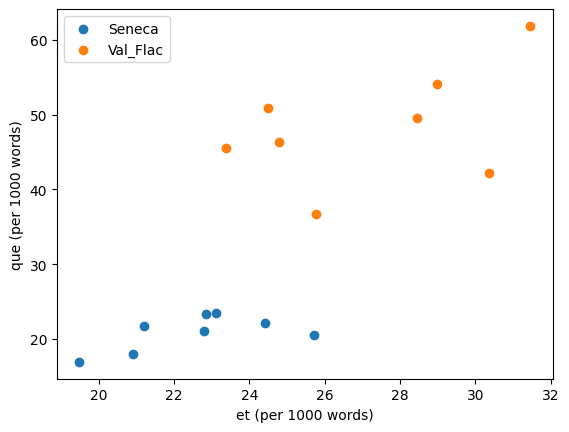

In [104]:
# features of interest
x_feat = 'et'
y_feat = 'que'

# create a new plot
fig, ax = plt.subplots()

# iterate over the authors
for label, group in lemma_freq.groupby('author'):
    
    # add a series points for this author
    ax.scatter(group[[x_feat]], group[[y_feat]], label=label)

# add figure labels and legend
ax.set_xlabel(x_feat + ' (per 1000 words)')
ax.set_ylabel(y_feat + ' (per 1000 words)')
ax.legend()

# show
plt.show()

<div class="alert alert-success">
<h3>🤔 Explore the data</h3>

<p style="margin:1em 0em">As before, try plugging in lemmata of your choice here to see the resulting graph. Do the two authors' texts separate out, or do they overlap? If you get good separation, see if you can formalize it for yourself: try writing out a set of rules for classifying the texts according to feature frequency.</p>
</div>

<hr>

# Dimensionality reduction

A scatterplot works well for representing exactly two features, but we have 1400 in our table. How can we visualize the data in a way that uses as much of the available information as possible? This is the problem of **dimensionality reduction**: reducing 1400 dimensions to 2, for example, so that we can draw a plot, while minimizing information loss.

## Principal Components Analysis

One common technique is **principal components analysis**, or **PCA**. This involves projecting data into a new *n*-dimensional space... where *n* is a more convenient number than 1400.

The new dimensions, called **principal components**, are essentially a rotation and stretching of the original dimensions. For example, PC1 might be calculated using a formula that multiplies each dimension by some weight, or coefficient. For example,

$$
0.002963 \times \mbox{que} + 0.000504 \times \mbox{et} + 0.002526 \times \mbox{qui} + \dots + w_i \times X_i
$$

where $w_i$ is the $i$th weight and $X_i$ is the $i$th dimension.

This transformation is calculated so that PC1 represents the greatest possible variance among the data points. The second PC is the dimension orthogonal to PC1 that shows the next greatest variance, and so on.

### Performing PCA using sklearn

Actually calculating these weights and then projecting the data into the new space is a complicated operation. A popular tool for this process is the **scikit-learn** package, aka **sklearn**. The cell below instantiates a new 2-dimensional PCA model and then transforms our data.

In [132]:
# calculate the principal components
pca_model = PCA(n_components=2)

# project the data into the lower-dimensional space 
pca_feats = pca_model.fit_transform(lemma_freq)

# turn the PCA feature set into a data frame
pca_feats = pd.DataFrame(pca_feats, columns=['PC1', 'PC2'])

### Plotting PCs

Now that our 1400 lemmata have been projected down to two dimensions, we can plot them on a scatter plot. Because the new 2-dimensional dataset is in a different table, we need to call back to the original table for the author labels.

The new dimensions do not have meaningful units; rather, the relative positions of and distance between the points are what we're looking at.

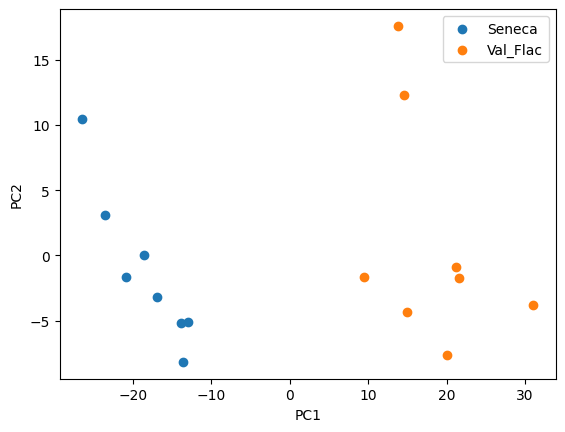

In [155]:
# create a new plot
fig, ax = plt.subplots()

# iterate over the authors
for label, group in pca_feats.groupby(lemma_freq.index.get_level_values('author')):
    
    # add a series points for this author
    ax.scatter(group.PC1, group.PC2, label=label)

# add figure labels and legend
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# show
plt.show()